# MLP

In [32]:
import torch
import os
import sys
sys.path.append('../../scaling_mlps/')
from models.networks import get_model
from torch import nn
import matplotlib.pyplot as plt

# from data_utils.data_stats import *
# from data_utils.dataset_to_beton import get_dataset
from utils.metrics import topk_acc, real_acc, AverageMeter

import numpy as np
import matplotlib.pyplot as plt

In [33]:
os.chdir("/home/guptav/DLProject-MLP/Experiments/Vansh/MLP")

In [34]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
eval_batch_size = 1024
checkpoint = 'in21k_cifar10'        # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10
data_path = '/home/vgspec/Personal/DLProject-MLP/Data'

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the model and specify the pre-trained weights
model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=CLASS_DICT[dataset],
                  checkpoint=None)
# model = model.to(device)
# model.eval()
model = nn.Sequential(
    nn.Flatten(1, -1),model
)

In [70]:
print(model)

#define transforms to preprocess input image into format expected by model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

#transforms to resize image to the size expected by pretrained model,
#convert PIL image to tensor, and
#normalize the image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(64),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BottleneckMLP(
    (linear_in): Linear(in_features=12288, out_features=1024, bias=True)
    (linear_out): Linear(in_features=1024, out_features=10, bias=True)
    (blocks): ModuleList(
      (0-11): 12 x BottleneckBlock(
        (block): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (layernorms): ModuleList(
      (0-11): 12 x LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
  )
)


In [71]:
def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [84]:
def resize_image(input_path, size=(64, 64)):
    # Open the image
    img = Image.open(input_path)
    
    # Resize the image to the specified size
    resized_img = img.resize(size)
    return resized_img

6
2
5


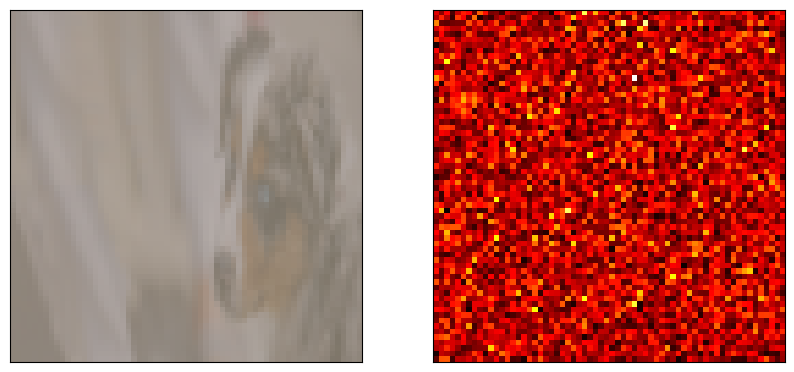

5


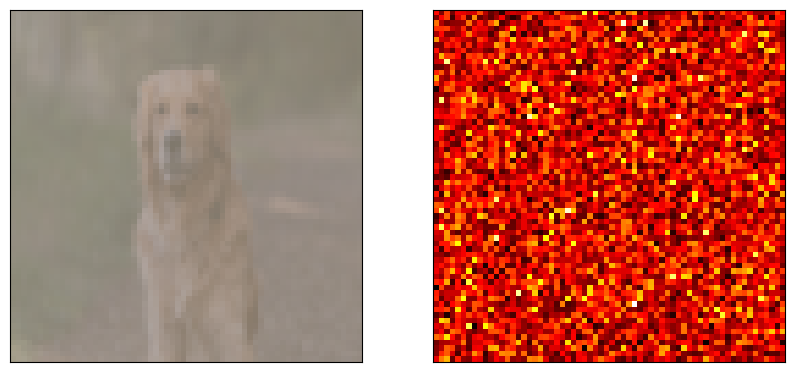

6
9
4
4
4
8
5


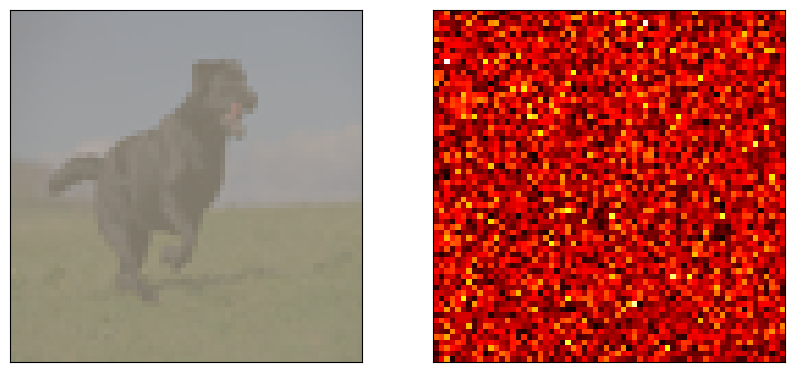

4
2
5


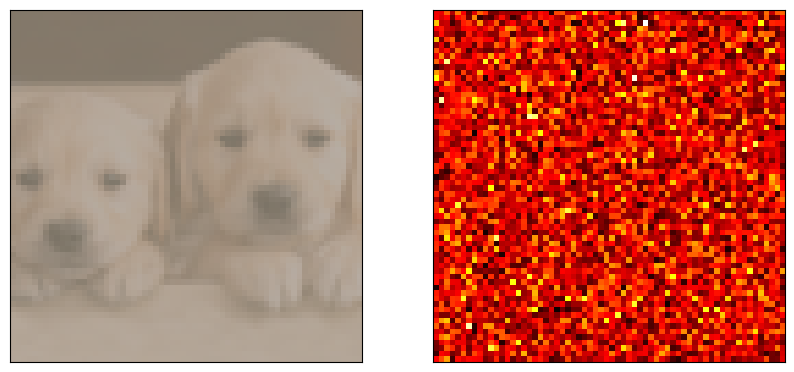

4
3
5


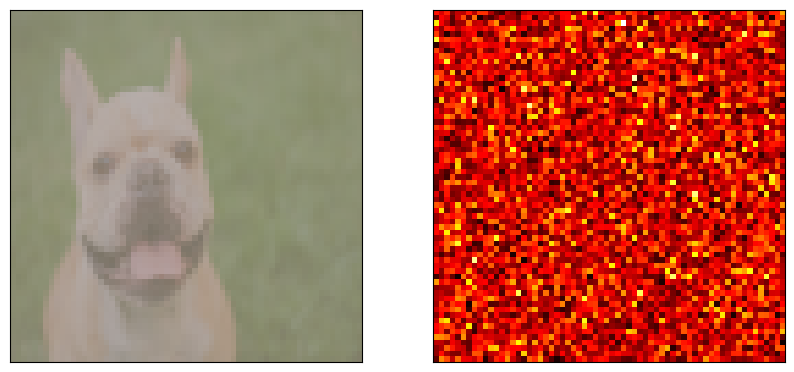

3
5


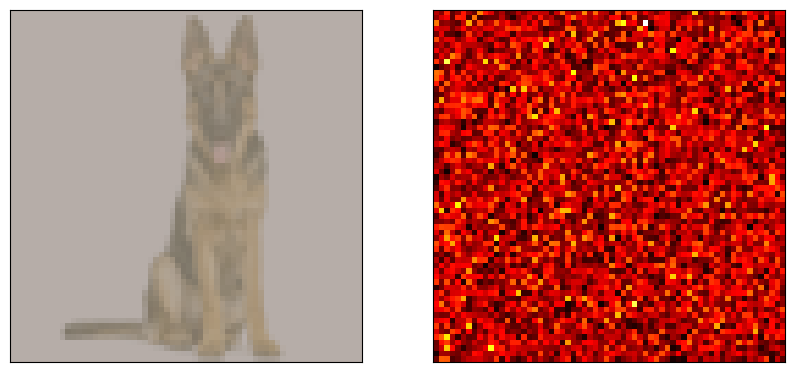

5


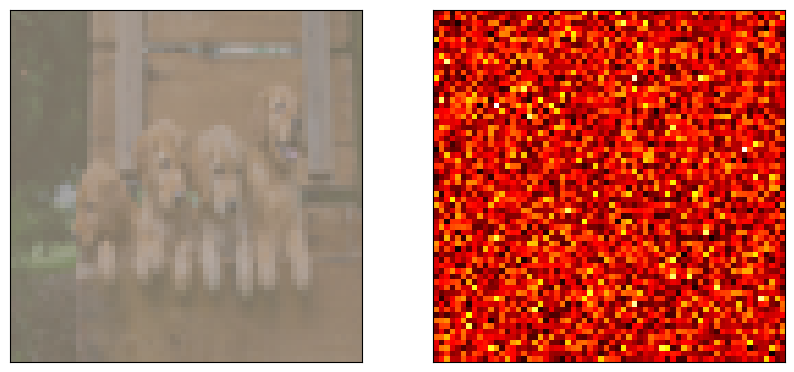

In [87]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
# classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
for i in range(20):
    path_img = f'/home/guptav/DLProject-MLP/Experiments/Vansh/Sample_Images/dog ({i+1}).jpg'
    img = resize_image(path_img)
    img_ten = transform(img).unsqueeze(0)
    output = model(img_ten)
    print(np.argmax(output.detach()).item())
    if (np.argmax(output.detach()).item() == 5):
        saliency(img, model)